# Breast Cancer pCR Classification

Clean, end-to-end notebook for predicting pathological complete response (pCR). Includes data inspection, preprocessing with leakage-safe pipelines, multiple model baselines, hyperparameter search, and a class-balanced CatBoost + SMOTE approach to address imbalance.

**How to read/run**
- Run setup/imports, then data loading/cleaning.
- Explore EDA plots to understand distribution and class balance.
- Run preprocessing + model sections; cross-validation uses balanced accuracy.
- Finish with the class-balanced CatBoost section for the best-performing approach.


In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [193]:
!pip install catboost


In [194]:
# ensure imbalanced-learn is available
%pip install -q imbalanced-learn

## Data Loading
Load the provided Excel dataset into a pandas DataFrame for inspection.


In [195]:
df = pd.read_excel("/content/TrainDataset2025.xls")

In [196]:
df

,ID,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,TRG002174,1,144.000000,41.0,0,0,0,1,3,3,...,0.517172,0.375126,3.325332,0.002314,3.880772e+06,473.464852,0.000768,0.182615,0.030508,0.000758
1,TRG002178,0,142.000000,39.0,1,1,0,0,3,3,...,0.444391,0.444391,3.032144,0.005612,2.372010e+06,59.459710,0.004383,0.032012,0.001006,0.003685
2,TRG002204,1,135.000000,31.0,0,0,0,1,2,1,...,0.534549,0.534549,2.485848,0.006752,1.540027e+06,33.935384,0.007584,0.024062,0.000529,0.006447
3,TRG002206,0,12.000000,35.0,0,0,0,1,3,3,...,0.506185,0.506185,2.606255,0.003755,6.936741e+06,46.859265,0.005424,0.013707,0.000178,0.004543
4,TRG002210,0,109.000000,61.0,1,0,0,0,2,1,...,0.462282,0.462282,2.809279,0.006521,1.265399e+06,39.621023,0.006585,0.034148,0.001083,0.005626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,TRG002948,0,54.500000,58.5,1,0,1,0,3,2,...,0.476493,0.476493,2.453583,0.003229,2.327038e+06,18.562377,0.013766,0.018042,0.000288,0.012257
396,TRG002954,0,49.250000,34.3,0,0,0,1,3,3,...,0.418382,0.418382,2.995603,0.004243,1.005061e+06,156.627179,0.002228,0.136015,0.022148,0.002098
397,TRG002958,0,48.500000,53.3,0,0,0,1,2,1,...,0.527779,0.527778,1.500000,0.003728,2.132007e+05,0.996746,0.252582,0.007380,0.000037,0.231059
398,TRG002961,0,47.500000,68.8,1,0,0,0,3,3,...,0.313693,0.313693,3.573557,0.001112,2.008034e+07,204.864200,0.001372,0.054063,0.003697,0.001368


In [197]:
df.describe()

,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,HistologyType,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000,...,4.000000e+02,4.000000e+02,4.000000e+02,400.000000,4.000000e+02,400.000000,400.000000,400.000000,400.000000,400.000000
mean,12.697500,56.000208,51.804674,0.547500,2.902500,2.797500,2.830000,9.875000,6.562500,8.63250,...,3.957637e-01,3.911005e-01,2.722189e+00,0.003347,5.679717e+07,178.311246,32500.032620,0.056935,0.005965,0.029322
std,111.107417,27.137584,10.948522,0.498362,49.932114,49.937068,49.935558,86.092911,70.444284,86.20034,...,1.666319e-01,1.615922e-01,7.648849e-01,0.002419,7.063846e+08,1045.453432,177545.921568,0.047179,0.008379,0.115915
min,0.000000,0.000000,23.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.00000,...,7.050000e-11,7.050000e-11,-3.200000e-16,0.000008,0.000000e+00,0.000000,0.000248,0.000000,0.000000,0.000000
25%,0.000000,38.000000,44.516769,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.00000,...,3.199017e-01,3.184398e-01,2.340783e+00,0.001389,1.030473e+06,18.760570,0.001826,0.018628,0.000310,0.001464
50%,0.000000,55.000000,51.019507,1.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.00000,...,4.095627e-01,4.054695e-01,2.814884e+00,0.002944,3.277334e+06,67.929659,0.004383,0.047740,0.002330,0.003276
75%,0.000000,73.000000,60.000000,1.000000,1.000000,1.000000,1.000000,3.000000,2.000000,1.00000,...,5.000049e-01,4.956920e-01,3.304411e+00,0.004798,9.079686e+06,157.370294,0.013769,0.085321,0.007962,0.009479
max,999.000000,144.000000,79.603012,1.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.00000,...,8.773779e-01,8.571429e-01,4.947427e+00,0.011301,1.390001e+10,20764.693790,1000000.000000,0.285100,0.060742,1.145601


In [198]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Columns: 121 entries, ID to original_ngtdm_Strength
dtypes: float64(108), int64(12), object(1)
memory usage: 378.3+ KB


## Data Cleaning
- Treat the sentinel value `999` as missing.
- Drop rows with `pCR (outcome)=999` (ambiguous labels).
- Replace remaining 999s with NaN for downstream imputation.


In [199]:
df.dtypes

,0
ID,object
pCR (outcome),int64
RelapseFreeSurvival (outcome),float64
Age,float64
ER,int64
...,...
original_ngtdm_Busyness,float64
original_ngtdm_Coarseness,float64
original_ngtdm_Complexity,float64
original_ngtdm_Contrast,float64


In [200]:
(df == 999).sum()[(df == 999).sum()>0]

# This particular table shows us the columns that have missing values in the form of 999.

,0
pCR (outcome),5
PgR,1
HER2,1
TrippleNegative,1
ChemoGrade,3
Proliferation,2
HistologyType,3
LNStatus,1
Gene,88


**Data Imputations:**

- Some clinical features in the dataset containg missing values (999), imputation is needed to replace these missing values so that machine learning models can process the data correctly.
- For the target column (pCR), rows with missing values will be dropped. as the outcome is required for training.
- For the remaining clinical features, we will use 'SimpleImputator' with the 'most_frequent' startegy to fill in the missing values.
- MRI features had no missing values, so no imputation was needed for them.
- This ensures a clean dataset for modeling

In [257]:
df = df[df['pCR (outcome)'] != 999]

## Exploratory Data Analysis
The following visualizations show feature distributions, class balance, and correlations among key clinical variables.


In [202]:
df = df.replace(999, np.nan)

In [253]:
df

,ID,pCR (outcome),RelapseFreeSurvival (outcome),Age,ER,PgR,HER2,TrippleNegative,ChemoGrade,Proliferation,...,original_glszm_SmallAreaHighGrayLevelEmphasis,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength
0,TRG002174,1,144.000000,41.0,0,0.0,0.0,1.0,3.0,3.0,...,0.517172,0.375126,3.325332,0.002314,3.880772e+06,473.464852,0.000768,0.182615,0.030508,0.000758
1,TRG002178,0,142.000000,39.0,1,1.0,0.0,0.0,3.0,3.0,...,0.444391,0.444391,3.032144,0.005612,2.372010e+06,59.459710,0.004383,0.032012,0.001006,0.003685
2,TRG002204,1,135.000000,31.0,0,0.0,0.0,1.0,2.0,1.0,...,0.534549,0.534549,2.485848,0.006752,1.540027e+06,33.935384,0.007584,0.024062,0.000529,0.006447
3,TRG002206,0,12.000000,35.0,0,0.0,0.0,1.0,3.0,3.0,...,0.506185,0.506185,2.606255,0.003755,6.936741e+06,46.859265,0.005424,0.013707,0.000178,0.004543
4,TRG002210,0,109.000000,61.0,1,0.0,0.0,0.0,2.0,1.0,...,0.462282,0.462282,2.809279,0.006521,1.265399e+06,39.621023,0.006585,0.034148,0.001083,0.005626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,TRG002948,0,54.500000,58.5,1,0.0,1.0,0.0,3.0,2.0,...,0.476493,0.476493,2.453583,0.003229,2.327038e+06,18.562377,0.013766,0.018042,0.000288,0.012257
396,TRG002954,0,49.250000,34.3,0,0.0,0.0,1.0,3.0,3.0,...,0.418382,0.418382,2.995603,0.004243,1.005061e+06,156.627179,0.002228,0.136015,0.022148,0.002098
397,TRG002958,0,48.500000,53.3,0,0.0,0.0,1.0,2.0,1.0,...,0.527779,0.527778,1.500000,0.003728,2.132007e+05,0.996746,0.252582,0.007380,0.000037,0.231059
398,TRG002961,0,47.500000,68.8,1,0.0,0.0,0.0,3.0,3.0,...,0.313693,0.313693,3.573557,0.001112,2.008034e+07,204.864200,0.001372,0.054063,0.003697,0.001368


**Data Visualisation**

<Axes: xlabel='Age', ylabel='Count'>

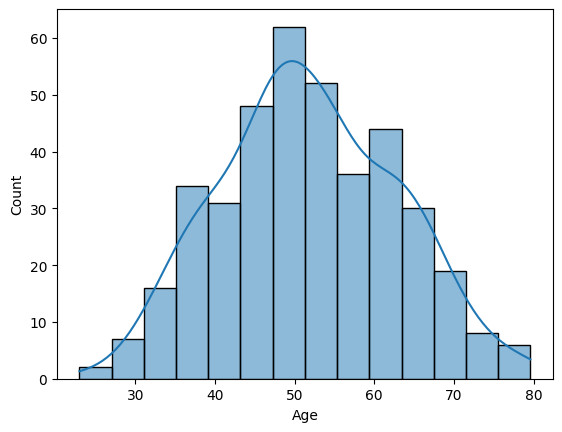

In [203]:
sns.histplot(df['Age'], kde=True)
# Allows us to see the distribution of the age feature
# and how ages are spread across the dataset.

<Axes: xlabel='pCR (outcome)', ylabel='Age'>

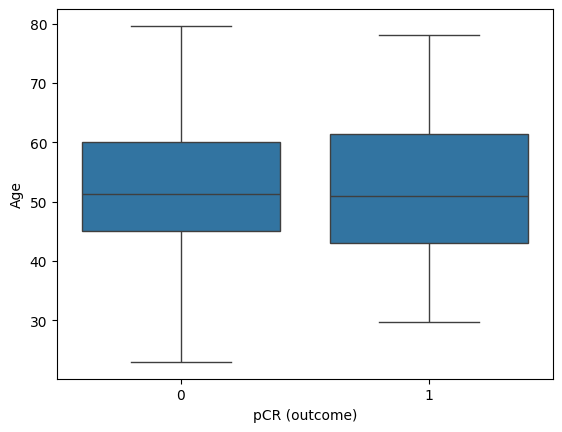

In [204]:
sns.boxplot(x = 'pCR (outcome)', y= 'Age', data = df)
# Feedback: Can possibly draw boxplots for all clinilca features

<Axes: xlabel='pCR (outcome)', ylabel='count'>

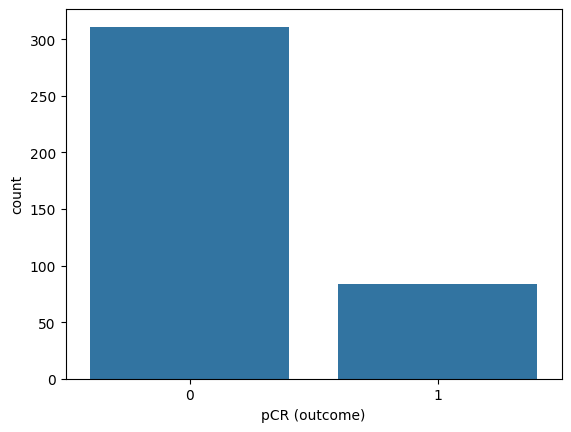

In [205]:
sns.countplot(x='pCR (outcome)', data=df)
# This diagram allows us to see the class balance
# From this diagram, we get the idea that it is imbalanced
# Slightly above 300 classify as 0 and less than 100 classify as 1
# Which shows that almost 25% of the woman achieve PCR

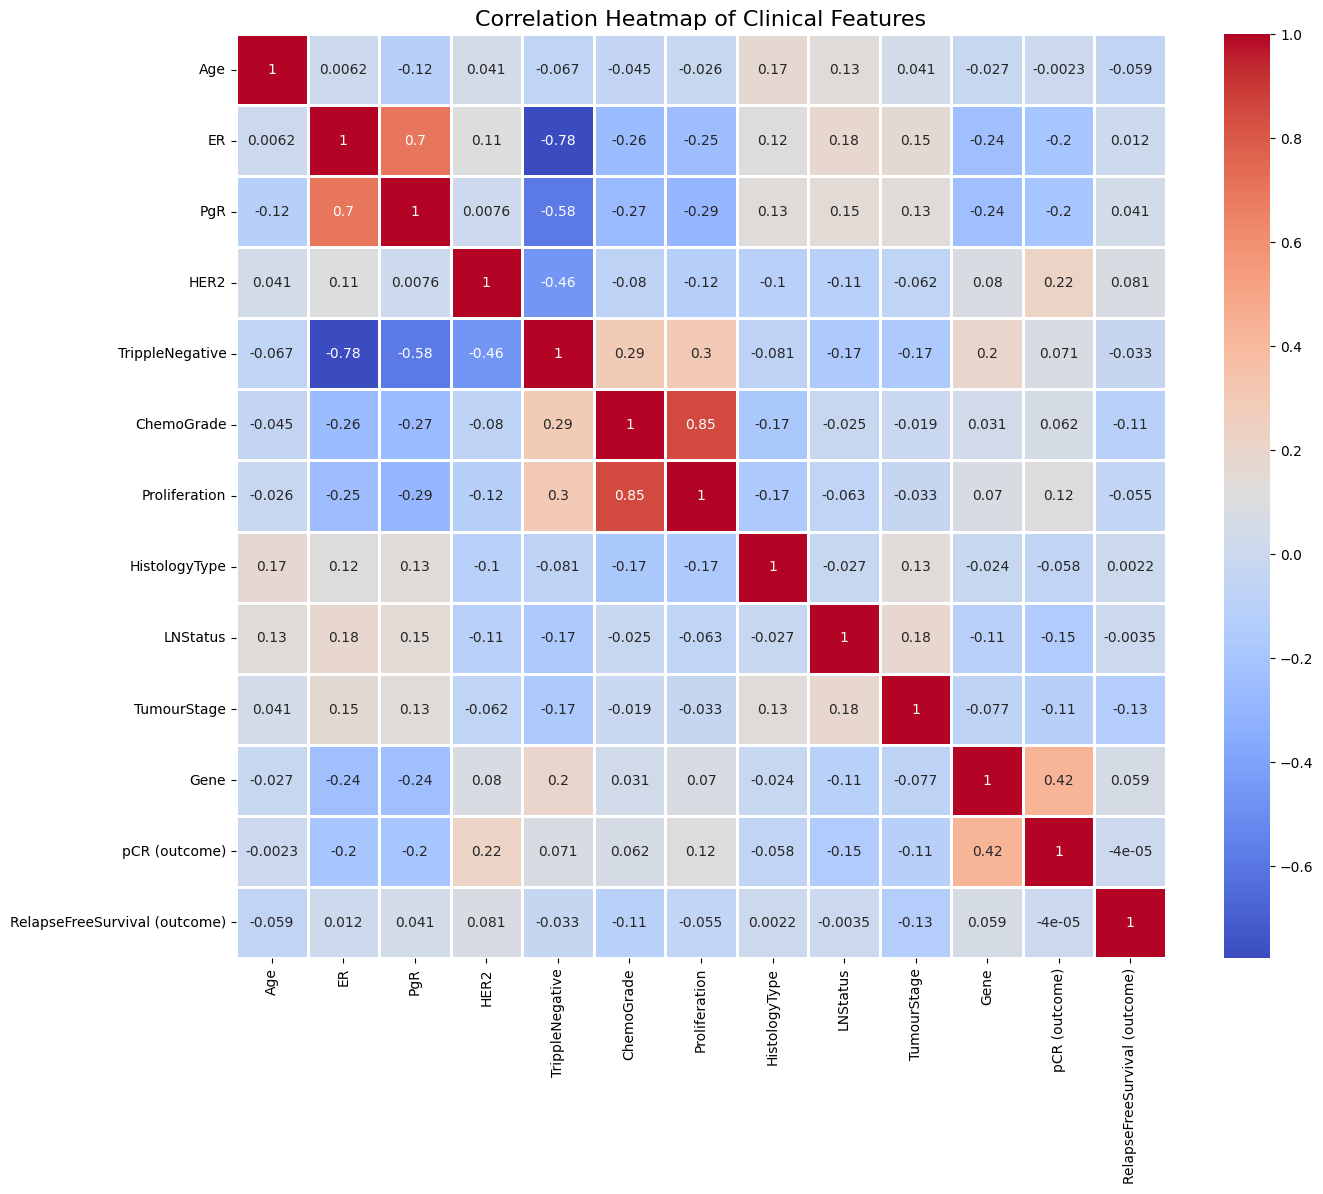

In [206]:
clinical_cols = ['Age', 'ER', 'PgR', 'HER2', 'TrippleNegative',
                 'ChemoGrade', 'Proliferation', 'HistologyType',
                 'LNStatus', 'TumourStage', 'Gene', 'pCR (outcome)', 'RelapseFreeSurvival (outcome)']

corrMatt = df[clinical_cols].corr()

plt.figure(figsize=(15, 12))  # Increase width and height
sns.heatmap(corrMatt, annot=True, cmap='coolwarm', fmt='.2g', linewidths=1)
plt.title('Correlation Heatmap of Clinical Features', fontsize=16)
plt.show()

<Axes: xlabel='HER2', ylabel='pCR (outcome)'>

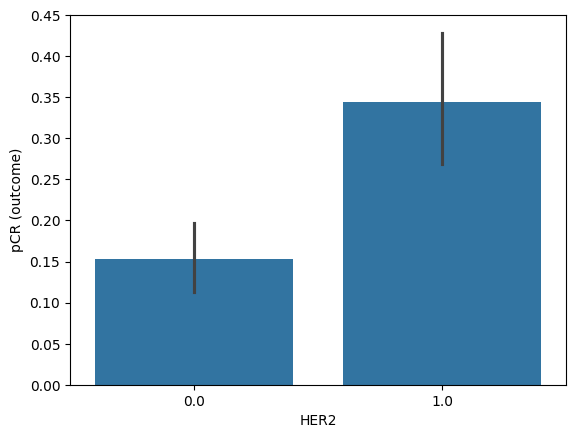

In [207]:
sns.barplot(x = 'HER2', y = "pCR (outcome)", data=df)

<Axes: xlabel='ER', ylabel='pCR (outcome)'>

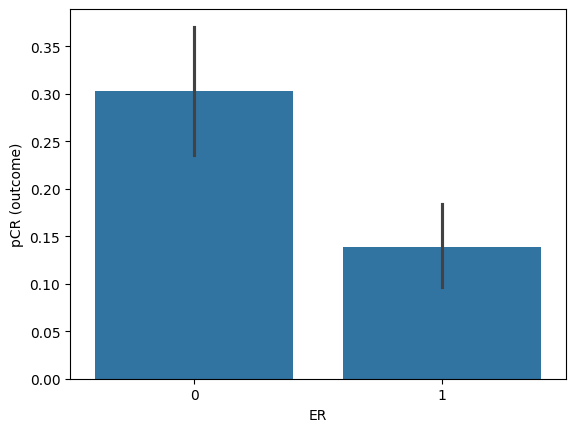

In [208]:
sns.barplot(x = 'ER', y = "pCR (outcome)", data=df)

<Axes: xlabel='Gene', ylabel='pCR (outcome)'>

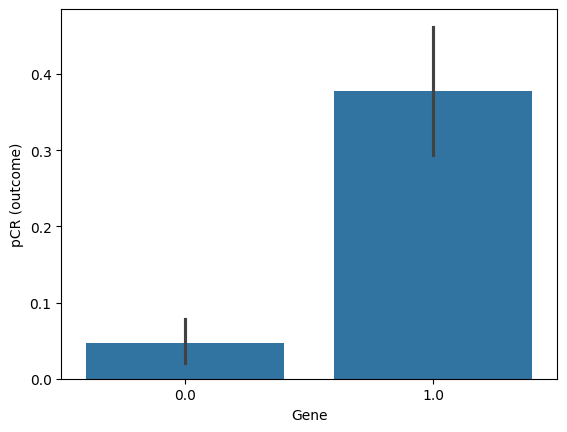

In [209]:
sns.barplot(x = 'Gene', y = "pCR (outcome)", data=df)

<Axes: xlabel='original_glszm_SmallAreaHighGrayLevelEmphasis'>

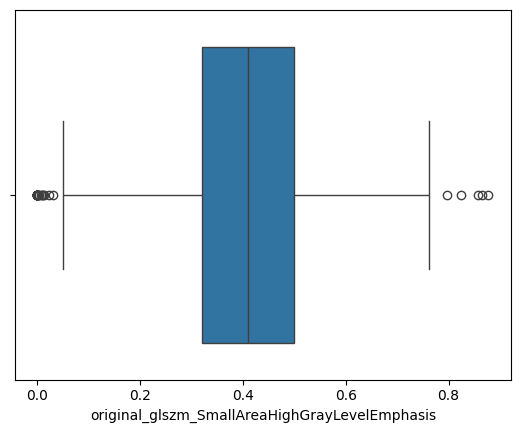

In [210]:
sns.boxplot(x = 'original_glszm_SmallAreaHighGrayLevelEmphasis', data = df)

<Axes: xlabel='original_glszm_ZoneEntropy'>

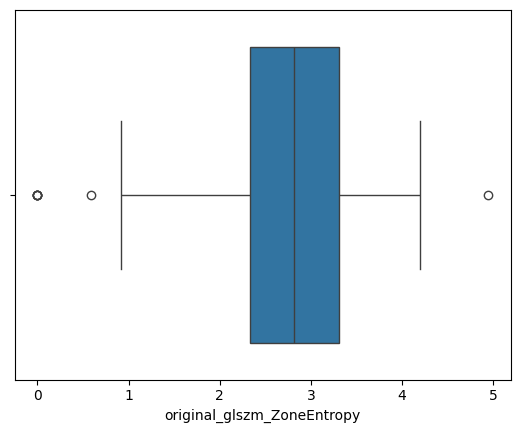

In [211]:
sns.boxplot(x = 'original_glszm_ZoneEntropy', data = df)

<Axes: xlabel='original_ngtdm_Strength'>

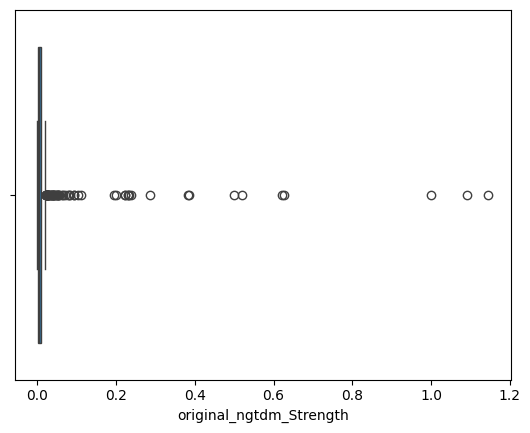

In [212]:
sns.boxplot(x = 'original_ngtdm_Strength', data = df)

<Axes: xlabel='original_ngtdm_Complexity'>

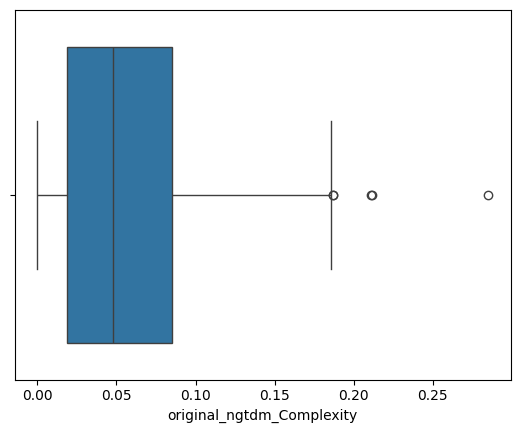

In [213]:
sns.boxplot(x = 'original_ngtdm_Complexity', data = df)

<Axes: xlabel='TumourStage', ylabel='count'>

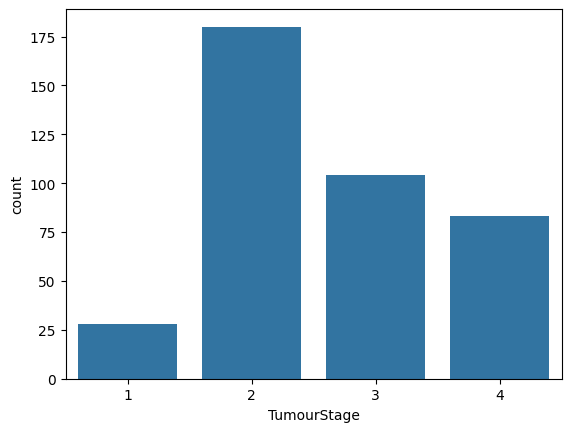

In [214]:
sns.countplot(x = "TumourStage", data = df)
# Visulaising 4 of the oridinal categotical features to see the distirbution of values

<Axes: xlabel='Proliferation', ylabel='count'>

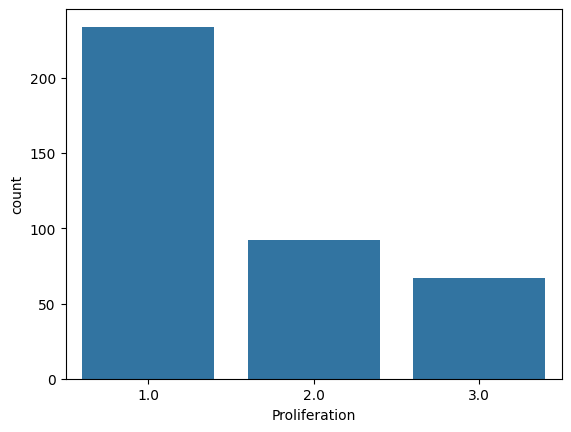

In [215]:
sns.countplot(x = 'Proliferation', data = df)
# Visulaising 4 of the oridinal categotical features to see the distirbution of values

<Axes: xlabel='HistologyType', ylabel='count'>

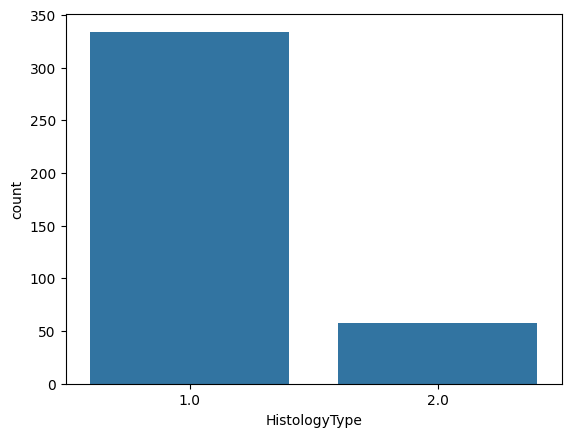

In [216]:
sns.countplot(x = 'HistologyType', data=df)
# Visulaising 4 of the oridinal categotical features to see the distirbution of values

<Axes: xlabel='ChemoGrade', ylabel='count'>

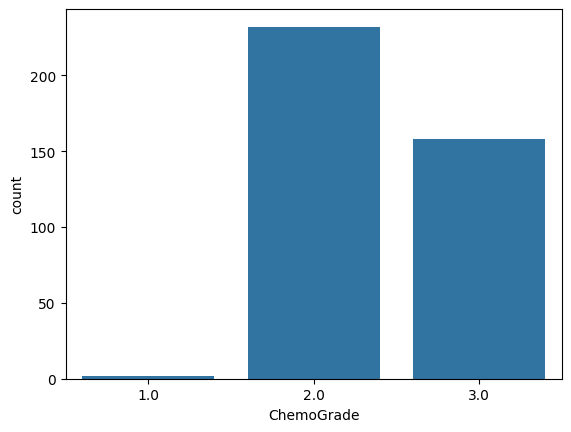

In [217]:
sns.countplot(x = 'ChemoGrade', data =df)
# Visulaising 4 of the oridinal categotical features to see the distirbution of values amongts features

<Axes: xlabel='original_ngtdm_Complexity', ylabel='Count'>

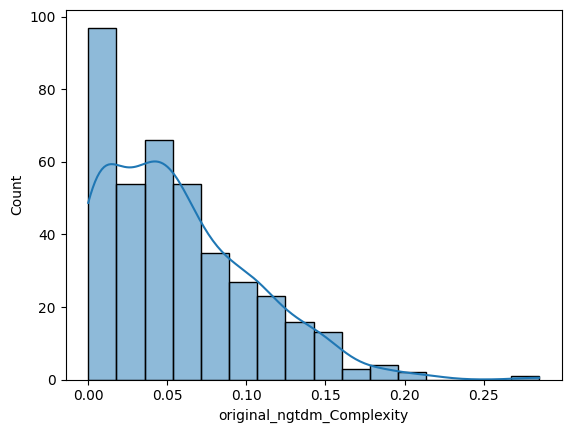

In [218]:
sns.histplot(df['original_ngtdm_Complexity'], kde=True)

<Axes: xlabel='original_glszm_SmallAreaHighGrayLevelEmphasis', ylabel='Count'>

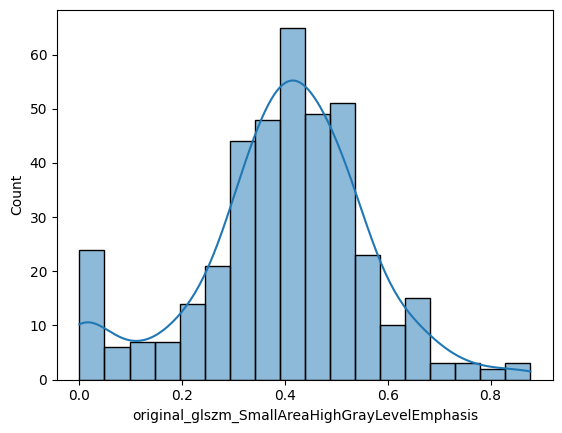

In [219]:
sns.histplot(df['original_glszm_SmallAreaHighGrayLevelEmphasis'], kde=True)

<Axes: xlabel='original_glszm_SmallAreaLowGrayLevelEmphasis', ylabel='Count'>

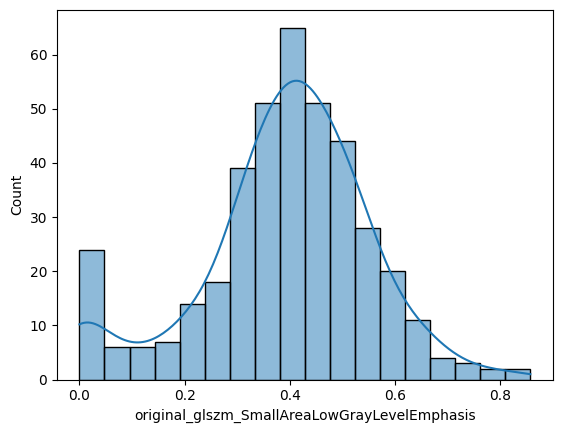

In [220]:
sns.histplot(df['original_glszm_SmallAreaLowGrayLevelEmphasis'], kde=True)

<Axes: xlabel='original_glszm_ZoneEntropy', ylabel='Count'>

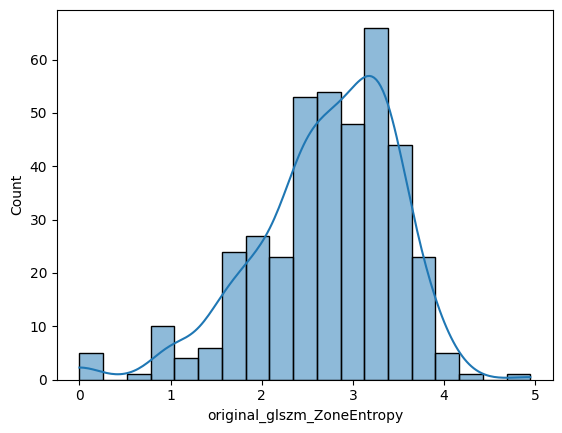

In [221]:
sns.histplot(df['original_glszm_ZoneEntropy'], kde=True)

## Preprocessing and Feature Engineering
- Handle outliers inside the pipeline to avoid leakage.
- Separate numeric, ordinal, and binary pipelines with imputers, scaling, and encoding as needed.
- Combine using `ColumnTransformer` so every model shares a consistent preprocessing step.


In [222]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import numpy as np

In [223]:
numerical_features = ['Age'] + [col for col in df.columns if col.startswith('original_')]

ordinal_features = ['ChemoGrade', 'Proliferation', 'HistologyType', 'TumourStage']

binary_features = ['ER', 'PgR', 'HER2', 'TrippleNegative', 'LNStatus', 'Gene']

In [224]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class OutlierCapper(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, factor=1.5):
        self.columns = columns
        self.factor = factor
        self.limits_ = {}

    def fit(self, X, y=None):
        for col in self.columns:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - self.factor * IQR
            upper = Q3 + self.factor * IQR
            self.limits_[col] = (lower, upper)
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            lower, upper = self.limits_[col]
            X[col] = np.where(X[col] < lower, lower, X[col])
            X[col] = np.where(X[col] > upper, upper, X[col])
        return X

**Feature Scaling/Standardisation:**

- Numeric features, including Age and MRI based continous features need to be standardised to bring them onto a common scale..
- This step in data pre processing stage ensures that models sensitive to feature magnitude such as neural networks treat all numeric features equally.
- To perform feature standardisation, we plan to use StandardScaler to standardise numeric columns while leaving binary and one hot encoded categorical features unchanged.
- We chose StandardScaler instead of RobustScaler because RobustScaler is mainly useful when numeric features have extreme outliers, which is not true in our case.


**Encoding**

- Binary features (0/1): pCR, ER, PgR, HER2, TrippleNegative, LNStatus and Gene. Hence, no encoding needed as they are already numeric
- Ordinal Categorical Features: ChemoGrade, Proliferation, HistologyType and TumourStage. One hot encoding would be used.
- Quantitative: Age is the only quantitative variable/feature and for that, no encoding is required. Would later be standardised if needed.

**Outlier Detection and Handling:**

- Most clinical features are either binary or ordinal categorical, so outlier detection is not applicable, and any missing values (999) are handled using the Simple Imputer.
- Since MRI-based features are continuous, so it is necessary to check for outliers and handle them appropriately.
- We will handle the outliers using the capping method instead of the removal method to preserve the data while replacing extreme values with acceptable limits.
- As a result of this, all MRI based features will become free of outliers.

In [225]:
numeric_transformer = Pipeline(steps=[
    ('outlier_cap', OutlierCapper(columns = numerical_features)),
    ('scaler', StandardScaler())
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoding', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

In [226]:
preprocessor = ColumnTransformer(transformers =[
    ('num', numeric_transformer, numerical_features),
    ('ord', ordinal_transformer, ordinal_features),
    ('bin', binary_transformer, binary_features)
])

## Baseline Models and Learning Curves
Now, down below we will explore how different models perform and learn from the data when trained on increasing portions of the training set (40%, 60%, 80%, and 100%), essentially observing their learning curves. Models include LGBM, CatBoostClassifier, MLP and XGBoost (with/without LDA).


## Train/Test Split and Cross-Validation Setup
- Stratified split (80/20) to preserve class balance.
- 5-fold StratifiedKFold for cross-validation.
- Balanced accuracy used as the primary metric to account for class imbalance.

In [227]:
from sklearn.model_selection import train_test_split

X = df.drop(['pCR (outcome)', 'ID', 'RelapseFreeSurvival (outcome)'], axis=1)
y = df['pCR (outcome)']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train.shape, X_test.shape

((316, 118), (79, 118))

In [228]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from catboost import CatBoostClassifier

CBC_pipeline = Pipeline(steps = [
    ('preprocessing', preprocessor),
    ('model', CatBoostClassifier(
    iterations=200,
    learning_rate=0.03,
    depth=6,
    verbose=0,
    random_seed=42
))
])

train_sizes = [0.4, 0.6, 0.8, 1.0]
sk_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state = 42)

In [229]:
def evaluate_learning_curve(model_pipeline, X_train, y_train):

  results = {}

  for size in train_sizes:
    x_sub = X_train[:int(len(X_train)*size)]
    y_sub = y_train[:int(len(y_train)*size)]

    cv_scores = cross_val_score(model_pipeline, x_sub, y_sub, cv = sk_fold, scoring='balanced_accuracy')

    results[size] = {
        'train_size' : len(x_sub),
        'cv_mean' : np.mean(cv_scores),
        'cv_std' : np.std(cv_scores)
    }

  return results

CBC_results = evaluate_learning_curve(CBC_pipeline, X_train, y_train)
CBC_results

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


{0.4: {'train_size': 126,
  'cv_mean': np.float64(0.5254761904761904),
  'cv_std': np.float64(0.03201119418715868)},
 0.6: {'train_size': 189,
  'cv_mean': np.float64(0.505),
  'cv_std': np.float64(0.03711842908553346)},
 0.8: {'train_size': 252,
  'cv_mean': np.float64(0.5227439024390244),
  'cv_std': np.float64(0.024076951293326206)},
 1.0: {'train_size': 316,
  'cv_mean': np.float64(0.5315635792778649),
  'cv_std': np.float64(0.04361212122924088)}}

In [230]:
from lightgbm import LGBMClassifier

lgbm_pipeline = Pipeline(steps = [
    ('preprocess', preprocessor),
    ('model', LGBMClassifier(verbose=-1, num_leaves=31, max_depth=1, learning_rate=0.1, n_estimators=100, random_state=42, boosting_type=None, objective=None, class_weight=None, subsample=1, ))

])

In [231]:
def evaluate_learning_curve(model_pipeline, X_train, y_train):

  results = {}

  for size in train_sizes:
    x_sub = X_train[:int(len(X_train)*size)]
    y_sub = y_train[:int(len(y_train)*size)]

    cv_scores = cross_val_score(model_pipeline, x_sub, y_sub, cv = sk_fold, scoring='balanced_accuracy')

    results[size] = {
        'train_size' : len(x_sub),
        'cv_mean' : np.mean(cv_scores),
        'cv_std' : np.std(cv_scores)
    }

  return results

lgbm_results = evaluate_learning_curve(lgbm_pipeline, X_train, y_train)
lgbm_results

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/pyt

{0.4: {'train_size': 126,
  'cv_mean': np.float64(0.4957142857142857),
  'cv_std': np.float64(0.04240903296583765)},
 0.6: {'train_size': 189,
  'cv_mean': np.float64(0.5266666666666667),
  'cv_std': np.float64(0.05512611802847077)},
 0.8: {'train_size': 252,
  'cv_mean': np.float64(0.5076219512195121),
  'cv_std': np.float64(0.03109875655281848)},
 1.0: {'train_size': 316,
  'cv_mean': np.float64(0.560684458398744),
  'cv_std': np.float64(0.005965765505018373)}}

In [232]:
from xgboost import XGBClassifier

XGB_pipeline = Pipeline(steps = [
    ('preprocessing', preprocessor),
    ('model', XGBClassifier(n_estimators=100,max_depth=6,learning_rate=0.3,subsample=1,colsample_bytree=1,gamma=0,reg_alpha=0,reg_lambda=1,min_child_weight=1,scale_pos_weight=1, random_state=42))
])

In [233]:
def evaluate_learning_curve(model_pipeline, X_train, y_train):

  results = {}

  for size in train_sizes:
    x_sub = X_train[:int(len(X_train)*size)]
    y_sub = y_train[:int(len(y_train)*size)]

    cv_scores = cross_val_score(model_pipeline, x_sub, y_sub, cv = sk_fold, scoring='balanced_accuracy')

    results[size] = {
        'train_size' : len(x_sub),
        'cv_mean' : np.mean(cv_scores),
        'cv_std' : np.std(cv_scores)
    }

  return results

XGB_results = evaluate_learning_curve(XGB_pipeline, X_train, y_train)
XGB_results

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


{0.4: {'train_size': 126,
  'cv_mean': np.float64(0.5414285714285715),
  'cv_std': np.float64(0.1217558614437858)},
 0.6: {'train_size': 189,
  'cv_mean': np.float64(0.5577380952380954),
  'cv_std': np.float64(0.0571254933936229)},
 0.8: {'train_size': 252,
  'cv_mean': np.float64(0.5625271002710027),
  'cv_std': np.float64(0.045991525315529545)},
 1.0: {'train_size': 316,
  'cv_mean': np.float64(0.5723139717425431),
  'cv_std': np.float64(0.04748845761973723)}}

In [234]:
from sklearn.neural_network import MLPClassifier

MLP_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', MLPClassifier( hidden_layer_sizes=(100, 50), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='adaptive', learning_rate_init=0.001, max_iter=300, early_stopping=True, momentum=0.9, random_state=42 ))
])

In [235]:
def evaluate_learning_curve(model_pipeline, X_train, y_train):

  results = {}

  for size in train_sizes:
    x_sub = X_train[:int(len(X_train)*size)]
    y_sub = y_train[:int(len(y_train)*size)]

    cv_scores = cross_val_score(model_pipeline, x_sub, y_sub, cv = sk_fold, scoring='balanced_accuracy')

    results[size] = {
        'train_size' : len(x_sub),
        'cv_mean' : np.mean(cv_scores),
        'cv_std' : np.std(cv_scores)
    }

  return results

MLP_results = evaluate_learning_curve(MLP_pipeline, X_train, y_train)
MLP_results

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


{0.4: {'train_size': 126,
  'cv_mean': np.float64(0.49642857142857144),
  'cv_std': np.float64(0.018913216293557637)},
 0.6: {'train_size': 189,
  'cv_mean': np.float64(0.4966666666666667),
  'cv_std': np.float64(0.006666666666666665)},
 0.8: {'train_size': 252,
  'cv_mean': np.float64(0.49891598915989166),
  'cv_std': np.float64(0.02097082114481483)},
 1.0: {'train_size': 316,
  'cv_mean': np.float64(0.4993846153846154),
  'cv_std': np.float64(0.02226999467269565)}}

Applying LDA to the chosen models to see if the performance has improved.

In [237]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

models = {
    'MLP': MLPClassifier( hidden_layer_sizes=(100, 50), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='adaptive', learning_rate_init=0.001, max_iter=300, early_stopping=True, momentum=0.9, random_state=42 ),
    'XGBoost': XGBClassifier(n_estimators=100,max_depth=6,learning_rate=0.3,subsample=1,colsample_bytree=1,gamma=0,reg_alpha=0,reg_lambda=1,min_child_weight=1,scale_pos_weight=1, random_state=42),
    'CatBoostClassifier': CatBoostClassifier(iterations=200,learning_rate=0.03,depth=6,verbose=0,random_seed=42),
    'LGBM': LGBMClassifier(verbose=-1, num_leaves=31, max_depth=1, learning_rate=0.1, n_estimators=100, random_state=42, boosting_type=None, objective=None, class_weight=None, subsample=1, )

}

lda_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lda', LinearDiscriminantAnalysis())
])

lda_pipeline.fit(X_train, y_train)

X_train_lda = lda_pipeline.transform(X_train)
X_test_lda  = lda_pipeline.transform(X_test)

for name, model in models.items():
    print(f"\nEvaluating {name} after LDA...")
    model.fit(X_train_lda, y_train)
    y_pred = model.predict(X_test_lda)
    print("Balanced Accuracy:", round(balanced_accuracy_score(y_test, y_pred), 3))



Evaluating MLP after LDA...
Balanced Accuracy: 0.513

Evaluating XGBoost after LDA...
Balanced Accuracy: 0.483

Evaluating CatBoostClassifier after LDA...
Balanced Accuracy: 0.521

Evaluating LGBM after LDA...
Balanced Accuracy: 0.521


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


**Final Model Selection:**

After evaluating multiple models (CatBoost, XGBoost, LGBM, and MLP) using balanced accuracy, learning curves, testing their performance after applying dimensioanlity reduction (LDA) and cross validated performance, the MLP classifier showed the most consistent and reliable results. It achieved the highest balanced accuracy on the validation split while handling class imbalance effectively when combined with SMOTE. Therefore, the MLP model was selected as the final model.

Down below, we will be performing Hyperparameter tuning on MLP and testing it on the final test dataset.

In [239]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

param_grid_mlp = {
    'model__hidden_layer_sizes': [(50,50), (100,50), (150,100)],
    'model__activation': ['relu', 'tanh'],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate_init': [0.0005, 0.001, 0.005],
    'model__max_iter': [300, 500]
}

mlp_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lda', LinearDiscriminantAnalysis()),   # use LDA
    ('model', MLPClassifier(solver='adam', learning_rate='adaptive', random_state=42))
])

mlp_rnd = RandomizedSearchCV(
    estimator=mlp_pipe,
    param_distributions=param_grid_mlp,
    n_iter=20,
    scoring='balanced_accuracy',
    cv=5,
    n_jobs=-1,
    random_state=42
)

mlp_rnd.fit(X_train, y_train)
print("MLP Best Balanced Accuracy:", mlp_rnd.best_score_)
print("MLP Best Params:", mlp_rnd.best_params_)

MLP Best Balanced Accuracy: 0.6291742543171115
MLP Best Params: {'model__max_iter': 300, 'model__learning_rate_init': 0.005, 'model__hidden_layer_sizes': (150, 100), 'model__alpha': 0.01, 'model__activation': 'tanh'}


In [241]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import balanced_accuracy_score, accuracy_score, classification_report, confusion_matrix

if 'X_train' not in globals() or 'y_train' not in globals():
    X = df.drop(['pCR (outcome)', 'ID', 'RelapseFreeSurvival (outcome)'], axis=1)
    y = df['pCR (outcome)']
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

smote = SMOTE(random_state=42, k_neighbors=3)

mlp_balanced = ImbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', smote),
    ('model', MLPClassifier(
        hidden_layer_sizes=(150, 100),
        activation='tanh',
        alpha=0.01,
        learning_rate_init=0.005,
        max_iter=300,
        solver='adam',
        early_stopping=True,
        random_state=42
    ))
])


cv_scores = cross_val_score(mlp_balanced, X_train, y_train, cv=5, scoring='balanced_accuracy')
print('MLP+SMOTE CV balanced accuracy:', np.mean(cv_scores).round(3), '+/-', np.std(cv_scores).round(3))

mlp_balanced.fit(X_train, y_train)
y_pred = mlp_balanced.predict(X_test)
print('Test balanced accuracy:', round(balanced_accuracy_score(y_test, y_pred), 3))
print('Test accuracy:', round(accuracy_score(y_test, y_pred), 3))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred))
print('Report:\n', classification_report(y_test, y_pred))

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


MLP+SMOTE CV balanced accuracy: 0.639 +/- 0.071
Test balanced accuracy: 0.591
Test accuracy: 0.759
Confusion matrix:
 [[55  7]
 [12  5]]
Report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85        62
           1       0.42      0.29      0.34        17

    accuracy                           0.76        79
   macro avg       0.62      0.59      0.60        79
weighted avg       0.73      0.76      0.74        79



**Final Dataset Testing:**



In [258]:
final_test = pd.read_excel("/content/FinalTestDataset2025.xls")

In [259]:
X = df.drop(['pCR (outcome)', 'ID', 'RelapseFreeSurvival (outcome)'], axis=1)

In [260]:
X_final_test = final_test.drop(['ID'], axis=1)

final_model = mlp_balanced
final_model.fit(X, y)

final_predictions = final_model.predict(X_final_test)

output_pcr = pd.DataFrame({
    'ID': final_test['ID'],
    'pCR (outcome)': final_predictions
})

output_pcr.to_csv("FinalTestPCR.csv", index=False)

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1, 2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
